In [37]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import scipy

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [38]:
# Define data directories
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

In [39]:
# Data exploration
train_class_counts = {}
for class_name in os.listdir(train_dir):
    train_class_counts[class_name] = len(os.listdir(os.path.join(train_dir, class_name)))
print("Training Class Counts:", train_class_counts)


Training Class Counts: {'mountain': 2512, 'street': 2382, 'buildings': 2191, 'sea': 2274, 'forest': 2271, 'glacier': 2404}


In [40]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [41]:
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation/test data

In [42]:
batch_size = 32
image_size = (150, 150)

In [43]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse')  # Use 'sparse' for integer labels

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [44]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [45]:
idx_to_classes = {val:key for key, val in dict(train_generator.class_indices).items()}
idx_to_classes

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [46]:
def resnet_block(input_layer, filters, kernel_size, strides=(1, 1), activation='relu'):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # to solve vanishing gradient problem 
    # Apply skip connection
    if strides != (1, 1) or input_layer.shape[-1] != filters:
        input_layer = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_layer)
    x = Add()([x, input_layer])
    x = Activation(activation)(x)
    
    return x

def build_resnet(input_shape=(150, 150, 3), num_classes=6):
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = resnet_block(x, 64, (3, 3))
    x = resnet_block(x, 64, (3, 3))
    x = resnet_block(x, 64, (3, 3))
    
    x = resnet_block(x, 128, (3, 3), strides=(2, 2))
    x = resnet_block(x, 128, (3, 3))
    x = resnet_block(x, 128, (3, 3))
    
    x = resnet_block(x, 256, (3, 3), strides=(2, 2))
    x = resnet_block(x, 256, (3, 3))
    x = resnet_block(x, 256, (3, 3))
    
    x = resnet_block(x, 512, (3, 3), strides=(2, 2))
    x = resnet_block(x, 512, (3, 3))
    x = resnet_block(x, 512, (3, 3))
    
    x = AveragePooling2D((2, 2))(x)  # Adjust the pooling window size
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(input_layer, x)
    return model

# Build ResNet model
resnet_model = build_resnet()

In [47]:
# Compile the model
resnet_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

In [48]:
# Train the model
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/438 ━━━━━━━━━━━━━━━━━━━━ 4:18:59 36s/step - accuracy: 0.1562 - loss: 4.1142

I0000 00:00:1712439907.569571      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712439907.622457      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/438 ━━━━━━━━━━━━━━━━━━━━ 3:39 591ms/step - accuracy: 0.2590 - loss: 4.4248

W0000 00:00:1712439946.553851     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.4163 - loss: 2.0827

W0000 00:00:1712440083.017162     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 226s 437ms/step - accuracy: 0.4165 - loss: 2.0812 - val_accuracy: 0.4960 - val_loss: 1.2908
Epoch 2/20
  1/438 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.5312 - loss: 1.6031

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5312 - loss: 1.6031 - val_accuracy: 0.7500 - val_loss: 0.9167
Epoch 3/20


W0000 00:00:1712440101.635247      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 108s 242ms/step - accuracy: 0.5980 - loss: 1.0354 - val_accuracy: 0.5968 - val_loss: 0.9882
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - accuracy: 0.6562 - loss: 0.7804 - val_accuracy: 0.4583 - val_loss: 1.0665
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 106s 239ms/step - accuracy: 0.6648 - loss: 0.8991 - val_accuracy: 0.5000 - val_loss: 1.5169
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 88us/step - accuracy: 0.6250 - loss: 1.0026 - val_accuracy: 0.4167 - val_loss: 1.7769
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 106s 238ms/step - accuracy: 0.6973 - loss: 0.8299 - val_accuracy: 0.5652 - val_loss: 1.1137
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - accuracy: 0.6562 - loss: 1.2211 - val_accuracy: 0.6250 - val_loss: 1.0416
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 107s 240ms/step - accuracy: 0.7153 - loss: 0.7713 - val_accuracy: 0.6690 - val_loss: 0.9119
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 92us/step - accuracy: 0.8125 - loss: 0.6268 - val_ac

In [49]:
# Evaluate the model
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(test_generator, verbose=2)
print("\nResNet Model Test accuracy:", test_acc_resnet)

94/94 - 5s - 49ms/step - accuracy: 0.7980 - loss: 0.5798

ResNet Model Test accuracy: 0.7979999780654907


# Model Metrics

In [50]:
train_loss = resnet_history.history["loss"]
train_accuracy = resnet_history.history["accuracy"]
test_loss = resnet_history.history["val_loss"]
test_accuracy = resnet_history.history["val_accuracy"]

### Train Loss vs Validation Loss

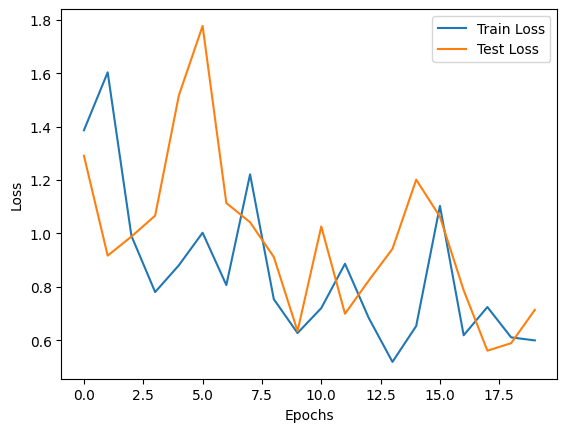

In [51]:
plt.plot(range(20), train_loss, label = "Train Loss")
plt.plot(range(20), test_loss, label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Train Accuracy vs Validation Accuracy

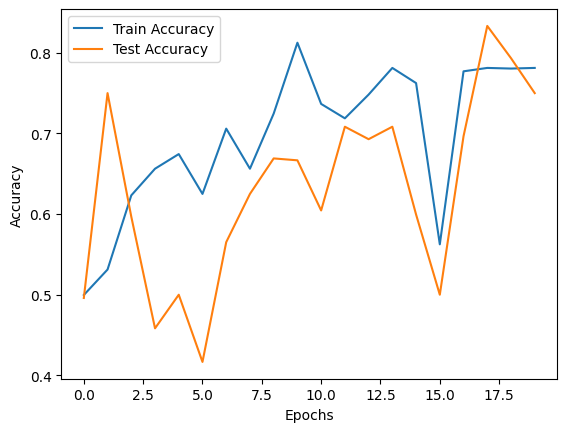

In [52]:
plt.plot(range(20), train_accuracy, label = "Train Accuracy")
plt.plot(range(20), test_accuracy, label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [53]:
pred_list = [rf"/kaggle/input/intel-image-classification/seg_pred/seg_pred/{i}" for i in os.listdir(r"/kaggle/input/intel-image-classification/seg_pred/seg_pred")]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


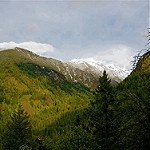

Model Prediction: mountain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


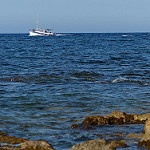

Model Prediction: sea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


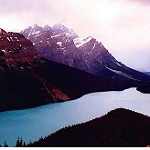

Model Prediction: mountain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


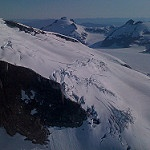

Model Prediction: glacier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


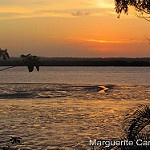

Model Prediction: sea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


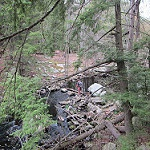

Model Prediction: forest
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


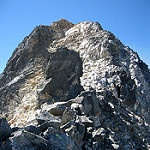

Model Prediction: buildings
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


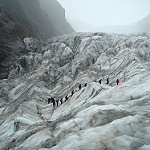

Model Prediction: glacier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


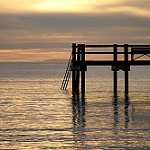

Model Prediction: sea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


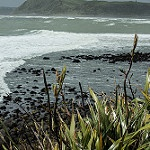

Model Prediction: sea


In [56]:
from random import randint
from PIL import Image

# Function to preprocess and predict images
def preprocess_and_predict(image_path, model):
    img = Image.open(image_path)
    img = img.resize((150, 150))  # Resize image to match model input shape
    img_arr = np.array(img)  # Convert image to numpy array
    img_arr = img_arr / 255.0  # Normalize pixel values
    img_arr = img_arr[np.newaxis, :]  # Add batch dimension
    probability = resnet_model.predict(img_arr)  # Predict probabilities
    pred = np.argmax(probability)  # Get predicted class index
    return idx_to_classes[pred]  # Return predicted class label

# Generate random images and make predictions
for i in range(10):
    num = randint(0, len(pred_list))
    image_path = pred_list[num]
    predicted_class = preprocess_and_predict(image_path, resnet_model)
    
    # Display the image and predicted class
    img = Image.open(image_path)
    display(img)
    print("Model Prediction:", predicted_class)
    print("==========================================")
